In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns
import scipy.stats as st

# CLUSTERING JERÁRQUICO PARA IDENTIFICACIÓN DE OUTLIERS

Previo a entrenar el modelo, hacen agrupación jerárquica de datos, así podemos comprobar relaciones complejas y eliminar valores atípicos. 

## 2. IMPORTACIÓN DE DATOS

In [13]:
data = pd.read_csv('Gestational-Diabetes-COMPLETE.csv')

In [16]:
data.head()

,Age,No of Pregnancy,Gestation in previous Pregnancy,BMI,HDL,Family History,unexplained prenetal loss,Large Child or Birth Default,PCOS,Sys BP,Dia BP,OGTT,Hemoglobin,Sedentary Lifestyle,Prediabetes,Class Label(GDM /Non GDM)
0,22,2,1,21.231621,55.0,0,0,0,0,102.0,69,158.340759,12.0,0,0,0
1,26,2,1,22.290199,53.0,0,0,0,0,101.0,63,94.553606,12.4,0,0,0
2,29,1,0,45.715423,50.0,0,0,0,0,118.0,79,297.914461,14.3,0,0,0
3,28,2,1,24.204479,51.0,0,0,0,0,99.0,70,150.847222,15.0,0,0,0
4,21,2,1,25.957549,52.0,0,0,0,0,116.0,65,229.354507,15.0,0,0,0


In [21]:
columns_to_drop = [
    "No of Pregnancy",
    "Gestation in previous Pregnancy",
    "Family History",
    "Large Child or Birth Default",
    "unexplained prenetal loss",
    "PCOS",
    "HDL",
    "Hemoglobin",
    "Sedentary Lifestyle"
]

data_cleaned = data.drop(columns=columns_to_drop, errors='ignore')

In [24]:
data_cleaned.describe()

,Age,BMI,Sys BP,Dia BP,OGTT,Prediabetes,Class Label(GDM /Non GDM)
count,3525.000000,3525.000000,3525.000000,3525.000000,3525.000000,3525.000000,3525.000000
mean,32.581277,27.833896,135.409186,81.538156,170.898614,0.293050,0.389220
std,6.169107,5.880697,22.908813,11.379758,48.493910,0.455226,0.487643
min,20.000000,13.050990,81.451425,60.000000,70.784854,0.000000,0.000000
25%,28.000000,24.193773,121.000000,74.000000,142.000000,0.000000,0.000000
50%,32.000000,27.500000,132.090338,81.000000,156.000000,0.000000,0.000000
75%,37.000000,31.053367,153.000000,86.000000,195.395499,1.000000,1.000000
max,45.000000,45.962057,192.124164,124.000000,414.142451,1.000000,1.000000


Podemos observar que: 
<ol>
    <li>BMI:  La mayoría de las personas en el conjunto de datos tienen un BMI en el rango de sobrepeso u obesidad leve.</li>
    <li>Presión sistólica:  Los valores están algo elevados, con un rango amplio que incluye casos hipertensivos.</li>
    <li>Presión diastólica:La mayoría de los valores están dentro del rango normal, pero algunos casos podrían estar elevados</li>
    <li>OGTT: Los valores de OGTT muestran un rango amplio, con algunos casos de intolerancia a la glucosa.</li>
    <li> Prediabetes:  Un porcentaje significativo de personas están en riesgo de desarrollar diabetes</li>
    <li>Class Label:  Cerca del 40% de las personas en el conjunto de datos tienen diabetes gestacional, lo que es un porcentaje alto.</li>
    <li>En grandes rasgos, dado los valores de BMI, OGTT y Sys BP, parece que la muestra tienen tendencia a problemas metabólicos.</li>
</ol>

## 3. CLUSTERING 

Podemos aplicar el clustering jerárquico, el objetivo es identificar aquellos puntos que no se ajusten bien a ningún grupo o cluster, y marcarlos como outlier y asegurarnos previamente a meter los datos en el modelo. 

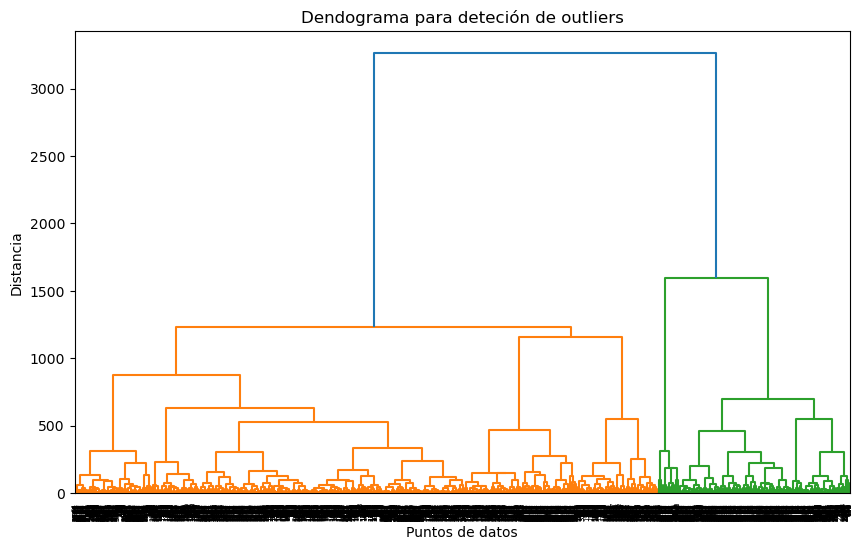

In [34]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
Z = linkage(data_cleaned, method = 'ward') #método ward minimiza la varianza dentro de los clusters

plt.figure(figsize=(10,6))
dendrogram(Z)
plt.title("Dendograma para deteción de outliers")
plt.xlabel("Puntos de datos")
plt.ylabel("Distancia")
plt.show()

**DESCRIPCIÓN DEL DENDROGRAMA**
<p>EJES</p>
<ul>
    <li>Eje X: representa los puntos de dtaos individuales en el dataset. Cada línea vertical corresponde a un punto o grupo de puntos a medida que se agrupan.</li>
    <li>Eje Y: Representa la distancia o disimilitud entre los puntos o los grupos cuando se fusionan.Cuanto mayor sea la altura de las líneas horizontales, mayor es la diferencia entre los grupos que se están uniendo.</li>
</ul>

<p>INTERPRETACIÓN</p>
<ul>
    <li>Grupos principales: El dendrograma muestra un corte en la parte superior, que divide los daros en dos grupos de dos colores:
        <ol>
            <li>Grupo naranja: es el grupo con mayor densidad de puntos, (más pequeños y cercanos entre sí).</li>
            <li>Grupo verde: Otro grupo que parece más ,compaccto, pero esta separado por una distancia significativa al resto.</li>
        </ol></li>
    <li>Distancia entre grupos:
        <ol>
            <li>El corte más alto (aproximadamente a una distancia de 3000) sugiere que existe un grupo potencial de outliers.</li>
            <li>Este grupo es pequeño y tendrá datos atípicos.</li>
        </ol></li>
    <li>Identificación de outliers:
        <ol>
            <li>Los puntos que se agrupan a distnacias altas, posiblemente sean outliers. En nuestro caso, para valores unidos en la rama más añta (por encima de 3000)</li>
        </ol></li>
    <li>Agrupamiento interno:
        <ol>
            <li>Dentro de los grupos principales (naranja y verde), losbdatos están más densamente conectados, como lo indica la menor altura de las uniones, cosa que sugiiere que estos puntos son más similares entre sí y menos probables de ser outliers.</li>
        </ol></li>
</ul>

**IDENTIFICACIÓN DE OUTLIERS**

Vamos a cortar el dendograma  en un umbral para identificarlos. Para ellos usamos <code>fcluster</code>

In [65]:
import cdistfrom scipy.cluster.hierarchy import fcluster
threshold = 2000
clusters = fcluster(Z, t=threshold, criterion='distance')

# Agregar clusters al DataFrame
data_cleaned['Cluster'] = clusters

In [75]:
# Identificarlos 
# Contar el tamaño de cada cluster
print(data_cleaned['Cluster'].value_counts())

Cluster
1    2655
2     870
Name: count, dtype: int64


Ambos clusters tienen un tamaño considereable,lo que significa que no hay clusters pequeños evidnetes que se puedan identificar como outliers basándonos únicamente en el tamaño de los clusters.  Esto indica que los datos no contienen puntos que estén agrupados en clusters muy pequeños.

**CÁLCULO DE DISTANCIA INDIVIDUALES AL CENTROIDE DE CADA CLUSTER**


In [81]:
from scipy.spatial.distance import cdist
import numpy as np


data_cleanedAux = data_cleaned.copy()
#dividir los datos en clusters
clus1 = data_cleanedAux[data_cleanedAux['Cluster'] == 1].drop(columns='Cluster').values
clus2 = data_cleanedAux[data_cleanedAux['Cluster'] == 2].drop(columns='Cluster').values

#calculo centroides
centroid1 = clus1.mean(axis=0)
centroid2 = clus2.mean(axis=0)

#calculo distancias al centroide
dist1 = cdist(clus1, [centroid1])
dist2 = cdist(clus2, [centroid2])

#identificar puntos con mayor distancia como outliers internos
threshold1 = np.percentile(dist1, 95) #top 5% más lejanos
threshold2 = np.percentile(dist2,95)

outliers1 = clus1[dist1.flatten() > threshold1]
outliers2 = clus2[dist2.flatten() > threshold2]


print(f"Outliers en cluster 1: {len(outliers1)}")
print(f"Outliers en cluster 2: {len(outliers2)}")

Outliers en cluster 1: 133
Outliers en cluster 2: 44


**VISUALIZACIÓN DE PUNTOS**

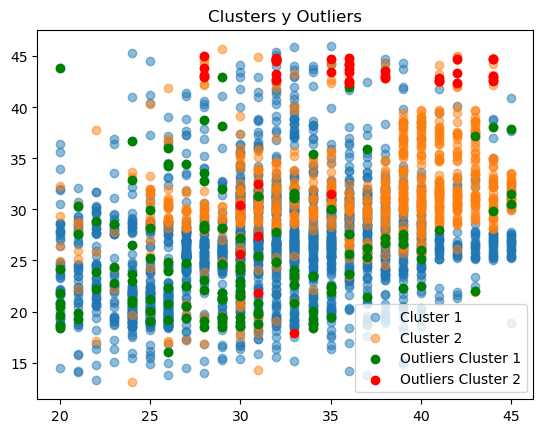

In [86]:
import matplotlib.pyplot as plt

plt.scatter(clus1[:,0], clus1[:,1], label='Cluster 1', alpha = 0.5)
plt.scatter(clus2[:,0], clus2[:,1], label='Cluster 2', alpha= 0.5)

#Destaca outliers
plt.scatter(outliers1[:,0], outliers1[:,1], color='green', label = 'Outliers Cluster 1')
plt.scatter(outliers2[:,0], outliers2[:,1], color='red', label = 'Outliers Cluster 2')
plt.legend()
plt.title("Clusters y Outliers")
plt.show()

No vamos a eliminar los outliers porque al observar la descripción estadística no parece que influyan mucho en la muestra , sino que aportan información de valores extremos, sin embargo esta bien identificarlos. 
Pero en caso de tener una baja precisión del modelo de predicción podemos recurrir a eliminarlos. 